# Embedding Representation for Categorical Variables


This notebook is an introduction to learn embeddings representation for **categorical variables**.

Through the notebook, we will follow the embedding processes from Matias Aravena Gamboa's blog: [Learning embeddings for your machine learning model](https://medium.com/spikelab/learning-embeddings-for-your-machine-learning-model-a6cb4bc6542e)

## Dataset

We will use the [Pokemon data](https://www.kaggle.com/abcsds/pokemon) with stats (just because it seems like a fun idea) dataset from Kaggle. The dataset includes information about 800 Pokemon's, including: name, type, HP, Attack, and other stats. Including a Total which is the sum of all stats:

In [50]:
import pandas as pd
import numpy as np
pokemon = pd.read_csv("Pokemon.csv")
pokemon.drop(labels="#", axis=1, inplace=True)
pokemon.fillna(value="No Type", axis=1, inplace=True)
pokemon.rename({'Type 1': 'type'}, inplace=True, axis=1)
pokemon.shape

(800, 12)

In [51]:
pokemon.head()

,Name,type,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,No Type,309,39,52,43,60,50,65,1,False


## Categorical variables

Among the features, the Pokemon types are categorical shown below

![](PokemonTypes.png)

and there are 18 pokemon types:

In [53]:
n_types = pokemon['type'].nunique()
print("We have:",n_types, "diferents pokemon types")

We have: 18 diferents pokemon types


## Encoding categorical variables in machine learning

Choosing the correct encoding of categorical data can improve the results of a model significantly. 

Two of the most well-known ways to convert categorical variables are **LabelEncoding** and **One Hot Encoding**:
* LabelEncoding converts the string labels into k integer values. The problem with LabelEncoding is that sometimes can bring a natural order on the different classes.
* One Hot Encoding creates k columns and set the variable value as 1 or 0 based on the category. However, One Hot Encoding may bring significant increase in feature dimension.

The other way is to encode categorical variables by learning embeddings. **An embedding is a mapping from discrete objects, such as words, to vectors of real numbers.** The individual dimensions in these vectors typically have no inherent meaning. Instead, it’s the overall patterns of location and distance between vectors that machine learning takes advantage of.

We use LabelEncoder to convert **type** from strings values into an integer, and a MinMaxScaler to scale **Total** (will be our `target variable`) into a range of [0,1]:

In [3]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
encoder = LabelEncoder()
scaler = MinMaxScaler()
pokemon['encoded_type'] = encoder.fit_transform(pokemon['type'])
pokemon['scaled_total'] = scaler.fit_transform(pokemon[['Total']])
types = pokemon['encoded_type']
total = pokemon['scaled_total']

In [9]:
types.head(10)

0     9
1     9
2     9
3     9
4     6
5     6
6     6
7     6
8     6
9    17
Name: encoded_type, dtype: int64

In [10]:
total.head()

0    0.230000
1    0.375000
2    0.575000
3    0.741667
4    0.215000
Name: scaled_total, dtype: float64

## Embedding Model

To visualize embedded types in **3D**, we choose the otuput embedding size:

In [104]:
embedding_size = 3

We implement embedding layer from Keras. 

In the Embedding layer, the hyperparameters include `input_dim` corresponds to the size of our vocabulary (18), `output_dim` is the size of our embedding and `input_length` is 1 because we are going to use only 1 word.

The model goal is to embed **type** to **total**, which are numeric values. Thus the activation function of the last layer is `linear`.

In [105]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
model = Sequential()
model.add(Embedding(input_dim=n_types,output_dim=embedding_size, input_length=1, name="poke_embedding"))
model.add(Flatten())
model.add(Dense(30, activation="relu"))
model.add(Dense(15, activation="relu"))
model.add(Dense(1, activation="linear"))

To compile the model, we are going to use `Adam` as optimizer and our loss function will be `mse` because the Total variable is continuous.

In [106]:
model.compile(optimizer='adam', loss='mse')
model.fit(x=types.values, y=total.values, epochs=30)

/Users/hsianghsuanhung/opt/anaconda3/envs/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
800/800 [==============================] - 0s 555us/step - loss: 0.1773
Epoch 2/30
800/800 [==============================] - 0s 40us/step - loss: 0.0837
Epoch 3/30
800/800 [==============================] - 0s 40us/step - loss: 0.0423
Epoch 4/30
800/800 [==============================] - 0s 41us/step - loss: 0.0393
Epoch 5/30
800/800 [==============================] - 0s 39us/step - loss: 0.0387
Epoch 6/30
800/800 [==============================] - 0s 37us/step - loss: 0.0381
Epoch 7/30
800/800 [==============================] - 0s 35us/step - loss: 0.0377
Epoch 8/30
800/800 [==============================] - 0s 37us/step - loss: 0.0372
Epoch 9/30
800/800 [==============================] - 0s 37us/step - loss: 0.0369
Epoch 10/30
800/800 [==============================] - 0s 36us/step - loss: 0.0367
Epoch 11/30
800/800 [==============================] - 0s 35us/step - loss: 0.0366
Epoch 12/30
800/800 [==============================] - 0s 36us/step - loss: 0.0367
Epoch 13/30


In [107]:
embedding_layer = model.get_layer(name="poke_embedding")
embedding_layer = pd.DataFrame(embedding_layer.get_weights()[0])
embedding_layer.columns = ['C1','C2','C3']

`embedding_layer` embeds each type from categorical value (Bug, Dark, Grass,...) to a 3-dimensional numeric vector. 

In [108]:
embedding_layer['type_name'] = encoder.inverse_transform([x for x in range(18)])
embedding_layer.head(18)

,C1,C2,C3,type_name
0,-0.051025,-0.115685,-0.054848,Bug
1,0.044206,-0.062854,0.048073,Dark
2,0.168122,-0.174493,0.148072,Dragon
3,0.066812,-0.089528,0.021586,Electric
4,0.025492,-0.026321,-0.019309,Fairy
5,0.007088,-0.023154,-0.013547,Fighting
6,-0.032718,-0.016822,0.086365,Fire
7,0.060563,0.024569,0.096618,Flying
8,-0.039524,0.045714,0.021114,Ghost
9,0.020485,-0.066738,0.011409,Grass


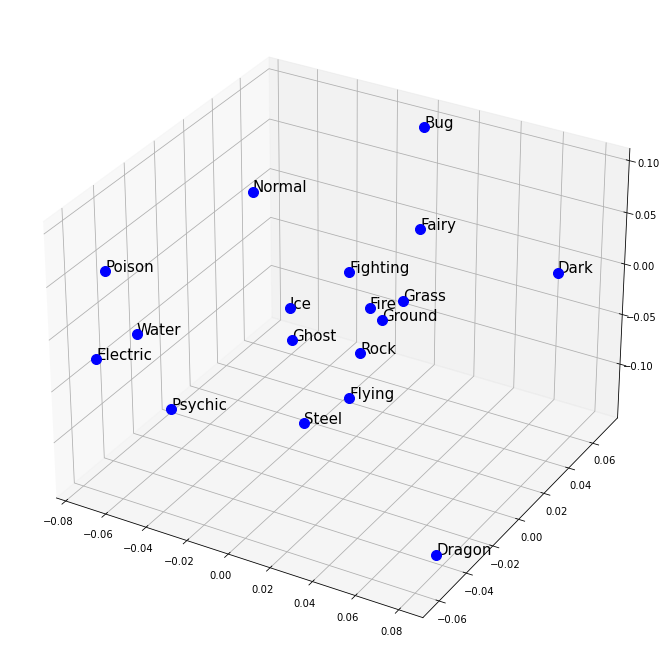

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')
for index, embedding in embedding_layer.iterrows():    
    x = embedding['C1']
    y = embedding['C2']
    z = embedding['C3']
    ax.scatter(x, y, z, s=100, color='blue')
    ax.text(x, y, z, '%s' % (embedding['type_name']), size=15, zorder=1, color='k')
plt.show()


## Embedding `type` to 2D and Visualize

In [109]:
embedding_size = 2

model = Sequential()
model.add(Embedding(input_dim=n_types,output_dim=embedding_size, input_length=1, name="poke_embedding"))
model.add(Flatten())
model.add(Dense(30, activation="relu"))
model.add(Dense(15, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(optimizer='adam', loss='mse')
model.fit(x=types.values, y=total.values, epochs=30)

/Users/hsianghsuanhung/opt/anaconda3/envs/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
800/800 [==============================] - 0s 554us/step - loss: 0.1491
Epoch 2/30
800/800 [==============================] - 0s 40us/step - loss: 0.0492
Epoch 3/30
800/800 [==============================] - 0s 41us/step - loss: 0.0405
Epoch 4/30
800/800 [==============================] - 0s 39us/step - loss: 0.0392
Epoch 5/30
800/800 [==============================] - 0s 38us/step - loss: 0.0384
Epoch 6/30
800/800 [==============================] - 0s 38us/step - loss: 0.0380
Epoch 7/30
800/800 [==============================] - 0s 38us/step - loss: 0.0373
Epoch 8/30
800/800 [==============================] - 0s 37us/step - loss: 0.0370
Epoch 9/30
800/800 [==============================] - 0s 38us/step - loss: 0.0367
Epoch 10/30
800/800 [==============================] - 0s 39us/step - loss: 0.0366
Epoch 11/30
800/800 [==============================] - 0s 39us/step - loss: 0.0366
Epoch 12/30
800/800 [==============================] - 0s 36us/step - loss: 0.0367
Epoch 13/30


In [116]:
embedding_layer = model.get_layer(name="poke_embedding")
embedding_layer = pd.DataFrame(embedding_layer.get_weights()[0])
embedding_layer.columns = ['C1','C2']
embedding_layer['type_name'] = encoder.inverse_transform([x for x in range(18)])

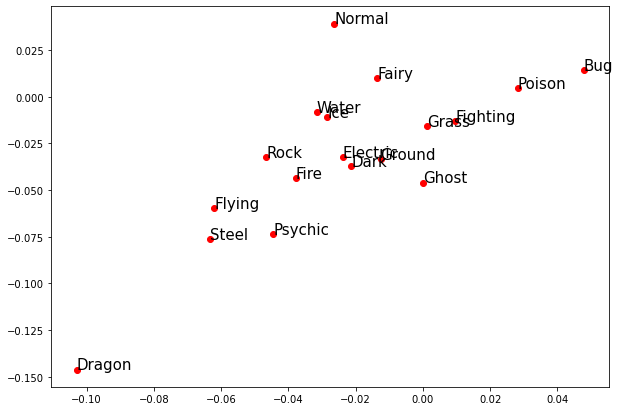

In [119]:
fig = plt.subplots(figsize=(10, 7))
for x, y, type_name in zip(embedding_layer['C1'], embedding_layer['C2'], embedding_layer['type_name']):
    plt.plot(x, y, 'ro')
    plt.text(x, y, '%s' % (type_name), size=15)

plt.show()

## Digression - Data visualization using t-SNE 

The pokemon data has label feature (`encoded_type`) and numeric features (`HP`, `Attack`,...). We can use t-SNE to visualize the data in 2D, and how the data respond to `Total`. 

In [23]:
from sklearn.manifold import TSNE
import seaborn as sns

In [19]:
tsne = TSNE()
X_embedded = tsne.fit_transform(pokemon[['encoded_type', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']])

/Users/hsianghsuanhung/opt/anaconda3/envs/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


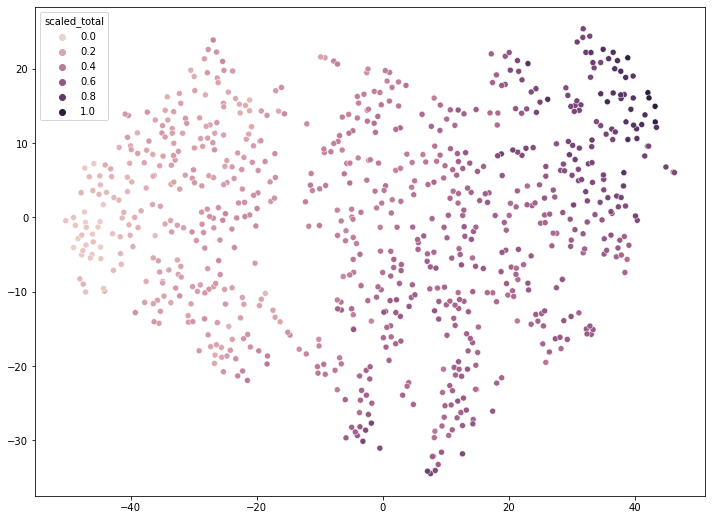

In [32]:
plt.figure(figsize=(12,9))
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], hue=total)
plt.show()

From the above, we can clearly see the relation between data and target variable `Total`, even before builing models. In short words, Pokemons in the half left have smaller `Total`, whereas half right larger `Total`. Such 2D visualization is helpful to gain insight.  